# Outline
1. Background
1. Load and Process
1. Algorithm 3.5
    1. Number of words and emojis
    1. Number of emojis
    1. Number of words
    1. Save results
    1. Number of unique words (WIP)
1. EDA
    1. Words + emojis
    1. Emojis
    1. Words

# Background

A modification of Algorithm 3 looking at the number of words per each 2 min chunk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from helpers import data_handler as d
from helpers import graph_helpers as gr

# Load and Process

In [2]:
data = json.load(open('data/big_data.json'))

In [3]:
big_df = d.organize_twitch_chat(data)

# Algorithm 3.5

## Number of words + emoticons

In [11]:
def results_formatter(dataframe, goal):
    '''
    Creates a new df `results` that contains the total number of words in the dataframe, the time
    the time the dataframe started and ended
    input
    -----
    dataframe: pd.DataFrame
        Dataframe with all the hours and chunks labeled, and num_words calculated
    goal: str
        Col name that has calculated results (ex: num_words, chat_rate, etc.)
    output
    ------
    results: pd.DataFrame
        Dataframe with `hour`, `chunk`, `start`, `end`, `num_words` columns
    '''
    hour_list = []
    chunk_list = []
    time_start_list = []
    time_end_list = []
    goal_list = []
    
    dataframe = dataframe.sort_values('created_at')
    # label each chunk with unique ID
    dataframe['category'] = dataframe['hour'].astype(str) + dataframe['chunk'].astype(str)
    
    for cat in dataframe['category'].unique():
        temp_df = dataframe[dataframe['category'] == cat] 
        hour_list.append(temp_df.iloc[0, -3])  # assumes hour col is 3 from end
        chunk_list.append(temp_df.iloc[0, -2])  # assumes hunk col is 2 from end
        time_start_list.append(temp_df.iloc[0, 0])  # assume created_at col is first
        time_end_list.append(temp_df.iloc[-1, 0])  # assume created_at col is first
        goal_list.append(temp_df[goal].sum())

    results = pd.DataFrame({
        'hour':hour_list,
        'chunk':chunk_list,
        'start':time_start_list,
        'end':time_end_list,
        goal:goal_list
    })
    return results

In [12]:
def num_words_in_chat(dataframe):
    '''
    Creates a new col `num_words_emo` that contains the number of words in each message
    '''
    word_bag = []
    body_split = dataframe['body'].str.split(' ')  # split each string at the whitespace
    for row in body_split:
        num_words = len(row)
        word_bag.append(num_words)
    
    dataframe['num_words_emo'] = word_bag
    return dataframe

## Number of emojis

In [29]:
big_df.iloc[2402]['body']

'lii1more lii1more lii1more'

In [30]:
big_df.iloc[2402]['emoticons']

[{'_id': '303368959', 'begin': 0, 'end': 7},
 {'_id': '303368959', 'begin': 9, 'end': 16},
 {'_id': '303368959', 'begin': 18, 'end': 25}]

Emoticon column can be seen as a "marker" for which chat message contained one or more emoticon. Each "marker" (row with emoticon in it) contains a list of dictionaries with:
* `_id`: twitch id of that emoticon
* `begin`: character index of the start of the emoticon reference
* `end`: character index of the end of the emoticon reference

1 dictionary = 1 emoticon

__This cell is the "algorithm"__

In [14]:
# find the number words (this includes emoticons)
big_df = num_words_in_chat(big_df)
# find the number of emoticons used in each message
# if the cell has a list, it has emoticon(s)
big_df['num_emo'] = big_df['emoticons'].apply(lambda x: len(x) if type(x) == list else 0)
# find the number of words only
big_df['num_words_only'] = big_df['num_words_emo'] - big_df['num_emo']

__The following function is just formatting__

In [15]:
first_stamp, chunk_list = d.get_chunks(big_df)

/home/jupyter-pomkos/projects/twitch_chat_analysis/helpers/data_handler.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['hour'] = i
/home/jupyter-pomkos/projects/twitch_chat_analysis/helpers/data_handler.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['chunk'] = x


In [16]:
chunk_df = pd.DataFrame(columns = chunk_list[0].columns)
for chunk in chunk_list:
    chunk_df = chunk_df.append(chunk)

## Save Results

In [17]:
# Format results
for col in ['num_words_emo','num_emo','num_words_only']:
    results = results_formatter(chunk_df, goal=col)
    json_results = d.results_jsonified(results, first_stamp, results_col = col)
    d.save_json(json_results,name=f'algo3.5_{col}')

Saved to data/algo3.5_num_words_emo.json
Saved to data/algo3.5_num_emo.json
Saved to data/algo3.5_num_words_only.json


## Number of unique words

# EDA

In [18]:
df_counts = chunk_df.groupby(['hour','chunk'])['num_emo','num_words_only'].sum().reset_index()

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


## Words + Emoji

In [19]:
# results df
results.head()

,hour,chunk,start,end,num_words_only,first_sec
0,0,0,2021-03-19 21:56:48.496000+00:00,2021-03-19 21:58:43.141000+00:00,13,2021-03-19 21:56:48.496000+00:00
1,0,1,2021-03-19 21:59:43.433000+00:00,2021-03-19 22:01:35.940000+00:00,16,2021-03-19 21:56:48.496000+00:00
2,0,2,2021-03-19 22:01:56.550000+00:00,2021-03-19 22:03:30.656000+00:00,41,2021-03-19 21:56:48.496000+00:00
3,0,3,2021-03-19 22:04:42.449000+00:00,2021-03-19 22:06:38.526000+00:00,50,2021-03-19 21:56:48.496000+00:00
4,0,4,2021-03-19 22:06:45.181000+00:00,2021-03-19 22:08:41.921000+00:00,63,2021-03-19 21:56:48.496000+00:00


In [20]:
# chunk_df df
chunk_words_sum = chunk_df.groupby(['hour','chunk'])['num_words_emo'].sum().reset_index()

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.6/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


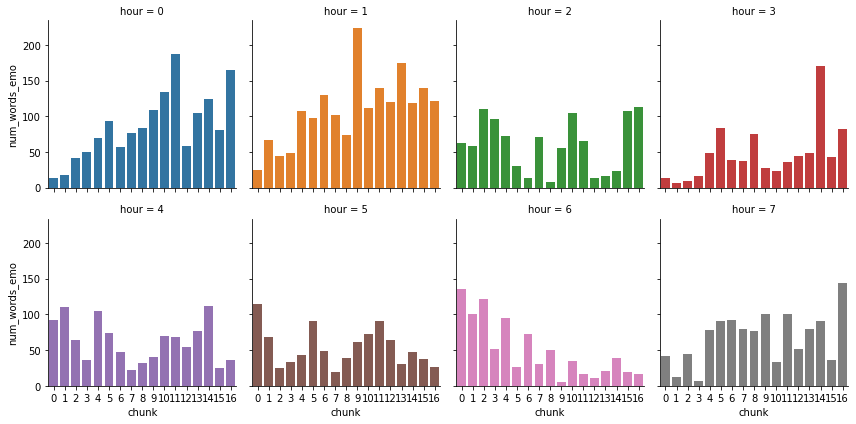

In [21]:
g = sns.FacetGrid(col='hour',data=chunk_words_sum, hue='hour', col_wrap = 4)
g.map(sns.barplot, 'chunk','num_words_emo')

## Emoji

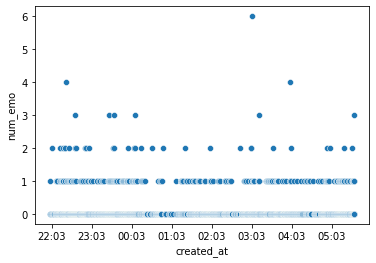

In [22]:
gr.plot_with_time(x='created_at', y='num_emo', data = chunk_df)

Text(0.5, 1.0, 'Mean number of emoticons each chunk per hour')

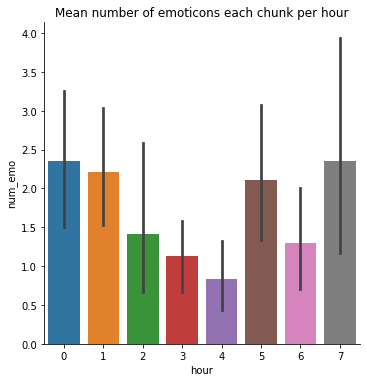

In [23]:
sns.catplot(x='hour',y='num_emo',data=df_counts, kind='bar')
plt.title("Mean number of emoticons each chunk per hour")

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.6/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


Text(0.5, 1.05, 'Number of emoticons per chunk each hour')

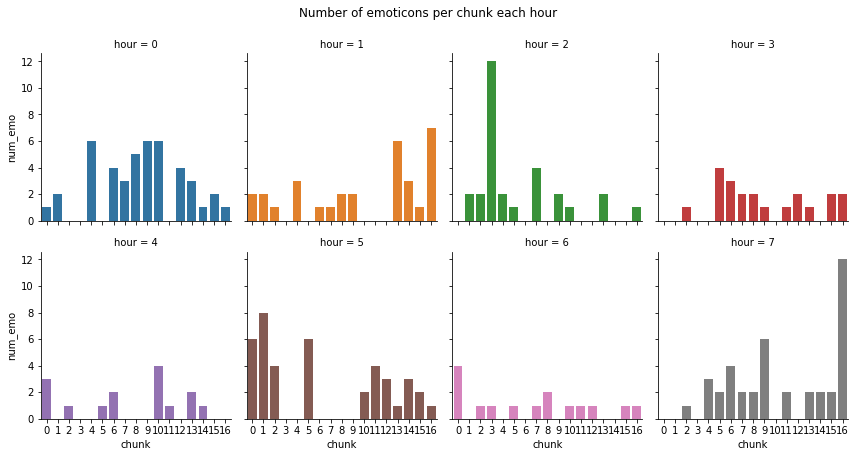

In [24]:
g = sns.FacetGrid(col='hour',data=df_counts, hue='hour', col_wrap = 4)
g.map(sns.barplot, 'chunk','num_emo')
plt.suptitle("Number of emoticons per chunk each hour",y=1.05)

## Words

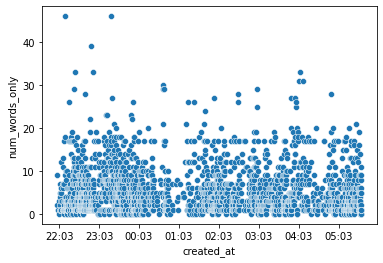

In [25]:
gr.plot_with_time(x='created_at', y='num_words_only', data = chunk_df)

Text(0.5, 1.0, 'Mean number of words each chunk per hour')

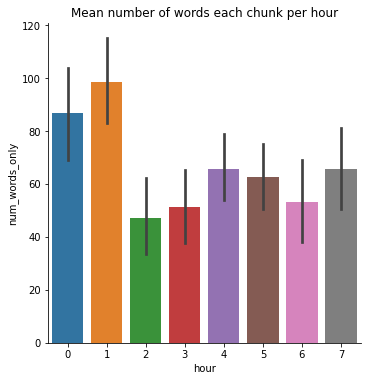

In [26]:
sns.catplot(x='hour',y='num_words_only',data=df_counts, kind='bar')
plt.title("Mean number of words each chunk per hour")

/home/jupyter-pomkos/.conda/envs/data_env/lib/python3.6/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


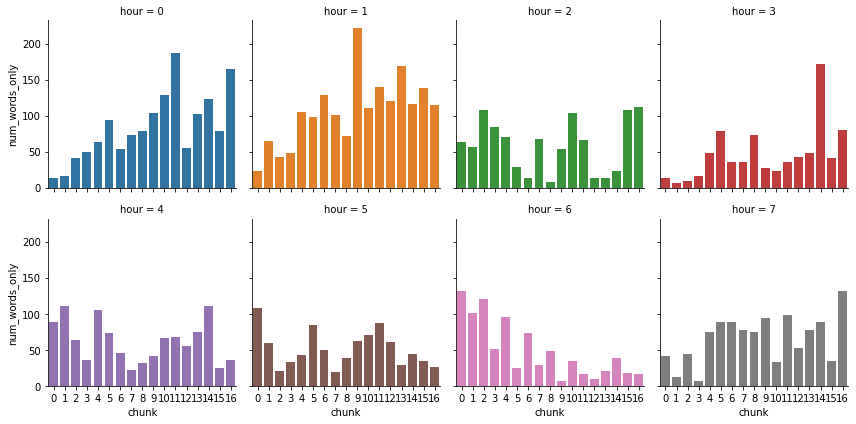

In [27]:
g = sns.FacetGrid(col='hour',data=df_counts, hue='hour', col_wrap = 4)
g.map(sns.barplot, 'chunk','num_words_only')